In [1]:
# Constants
DATA_PATH   = "../Data/Processed/2_preprocessed_df.pkl"

TECH_JOBS = ['Cloud infrastructure engineer',
             'Developer, embedded applications or devices',
             'Data or business analyst',
             'System administrator',
             'Developer, front-end',
             'Scientist',
             'DevOps specialist',
             'Developer, game or graphics',
             'Academic researcher',
             'Security professional',
             'Developer, QA or test',
             'Blockchain',
             'Developer, full-stack',
             'Data scientist or machine learning specialist',
             'Developer, mobile',
             'Developer, desktop or enterprise applications',
             'Developer, back-end',
             'Database administrator',
             'Engineer, data']

CORE_COLS = ['VersionControlSystem',
             'Languages',
             'Databases',
             'Platforms',
             'WebFrameworks',
             'MiscTech',
             'ToolsTech',
             'CollabTools'
]

In [2]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

_____

### Functions

_____

In [3]:
# Load dataset and make a copy
prep_df = pd.read_pickle(DATA_PATH)
df = prep_df.copy()

In [6]:
df

Techjobs                 \
      Data scientist or machine learning specialist Engineer, data   
2                                                 1              1   
3                                                 0              0   
4                                                 0              0   
7                                                 0              0   
8                                                 0              0   
...                                             ...            ...   
73263                                             0              0   
73264                                             1              0   
73265                                             0              0   
73266                                             0              0   
73267                                             0              1   

                                                                           \
      Data or business analyst Developer, back-end Database administrator   
2                            0                   0                      0   
3                            0                   0                      0   
4                            0                   1                      0   
7                            0                   0                      0   
8                            0                   1                      0   
...                        ...                 ...                    ...   
73263                        0                   1                      0   
73264                        0                   0                      0   
73265                        0                   0                      0   
73266                        0                   0                      0   
73267                        1                   1                      0   

                                                                             \
      Developer, mobile Developer, full-stack Cloud infrastructure engineer   
2                     0                     0                             0   
3                     0                     1                             0   
4                     0                     1                             0   
7                     0                     1                             0   
8                     0                     0                             0   
...                 ...                   ...                           ...   
73263                 0                     0                             0   
73264                 0                     0                             0   
73265                 0                     1                             0   
73266                 0                     0                             0   
73267                 1                     1                             1   

                                                                         \
      Developer, embedded applications or devices Developer, QA or test   
2                                               0                     0   
3                                               0                     0   
4                                               0                     1   
7                                               0                     0   
8                                               0                     0   
...                                           ...                   ...   
73263                                           0                     0   
73264                                           0                     0   
73265                                           0                     0   
73266                                           0                     0   
73267                                           1                     1   

                                                            \
      System administrator Scientist Security professional   
2 

### Create new features of skill clusters

In [8]:
# Get a Dataframe of the skills only
skills_df = df.droplevel(level=0, axis=1).drop(TECH_JOBS, axis=1).copy()

In [9]:
# Standardize the skills df
std_skills_df = StandardScaler().fit_transform(skills_df)

In [10]:
std_skills_df.shape

(57243, 164)

In [33]:
# Using T-SNE to visualize our high-dimensional dataset
tsne_projection = TSNE(n_components=2, 
                       perplexity=8,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=-1, 
                       n_iter=10**4,
                       random_state=42).fit_transform(std_skills_df.T)

tsne_projection = pd.DataFrame(tsne_projection, index=skills_df.columns)

In [34]:
tsne_projection.shape

(164, 2)

In [44]:
# Identify the right no. of clusters using silhoutte score
range_n_cluster = list(range(30,40))
silhoutte_score = []
best_cluster_model = None 

for n_clusters in range_n_cluster:
    cluster_model  = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection, cluster_labels)
    silhoutte_score += [silhouette_avg]
    
    if silhouette_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model

In [48]:
best_cluster_model

AgglomerativeClustering(n_clusters=38)

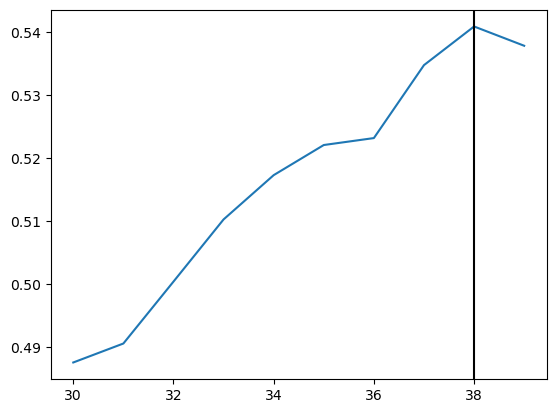

In [45]:
# Plot the silhoutte score of each no. of clusters
plt.plot(range_n_cluster, silhoutte_score)
plt.axvline(best_cluster_model.n_clusters, color='black')

In [50]:
# Change clusters names
cluster_labels = ["skills_group_" + str(label) 
                 for label in best_cluster_model.labels_]

In [47]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [90]:
# return skills in each cluster group as a list
skills_clusters = tsne_projection.index.to_series().groupby(cluster_labels).apply(list)

In [91]:
skills_clusters

skills_group_0     [Hugging Face Transformers, Keras, NumPy, Pand...
skills_group_1     [PHP, MariaDB, MySQL, OVH, Drupal, Laravel, Sy...
skills_group_10    [IBM DB2, Oracle, IBM Cloud or Watson, Oracle ...
skills_group_11    [HTML/CSS, JavaScript, TypeScript, React.js, Y...
skills_group_12                [Objective-C, Swift, Homebrew, Xcode]
skills_group_13                    [Assembly, C, C++, MATLAB, CLion]
skills_group_14    [Git, Ansible, Docker, Kubernetes, Pulumi, Ter...
skills_group_15               [Clojure, Haskell, LISP, OCaml, Emacs]
skills_group_16              [Atom, Eclipse, NetBeans, Sublime Text]
skills_group_17                                  [Lua, Rust, Neovim]
skills_group_18                             [Electron, React Native]
skills_group_19                          [Capacitor, Cordova, Ionic]
skills_group_2     [Scala, Cassandra, Neo4j, Play Framework, Apac...
skills_group_20                              [Deno, Fastify, Svelte]
skills_group_21      [SVN, Delphi,

In [94]:
new_features = []

for cluster, skills in skills_clusters.items():
    # Get the sum of skills in each cluster that appeared in each row of skills_df
    cluster_sum = skills_df[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

eng_skills_df = pd.concat(new_features, axis=1)

In [95]:
eng_skills_df

skills_group_0  skills_group_1  skills_group_10  skills_group_11  \
2                   1               0                0                3   
3                   0               0                0                3   
4                   0               1                0                5   
7                   1               2                0                6   
8                   0               0                0                0   
...               ...             ...              ...              ...   
73263               1               2                0                4   
73264               9               0                1                4   
73265               2               4                0                5   
73266               0               0                1                0   
73267               0               0                0                5   

       skills_group_12  skills_group_13  skills_group_14  skills_group_15  \
2                    0                1                1                0   
3                    0                0                1                0   
4                    2                0                3                0   
7                    0                3                1                0   
8                    0                0                1                1   
...                ...              ...              ...              ...   
73263                1                0                3                0   
73264                0                0                1                0   
73265                0                0                1                0   
73266                0                0                0                0   
73267                0                0                5                0   

       skills_group_16  skills_group_17  skills_group_18  skills_group_19  \
2                    0                0                0                0   
3                    0                0                0                0   
4                    0                1                0                0   
7                    3                0                0                0   
8                    0                0                0                0   
...                ...              ...              ...              ...   
73263                1                0                0                0   
73264                0                0                0                0   
73265                0                0                1                2   
73266                0                0                0                0   
73267                0                3                0                0   

       skills_group_2  skills_group_20  skills_group_21  skills_group_22  \
2                   0                0                0                0   
3                   0                0                0                0   
4                   1                0                0                0   
7                   1                0                0                0   
8                   0                0                0                0   
...               ...              ...              ...              ...   
73263               0                0                0                0   
73264               1                0                0                0   
73265               0                1                0                0   
73266               0                0                3                0   
73267               3                1                0                0   

       skills_group_23  skills_group_24  skills_group_25  skills_group_26  \
2                    0                1                0                0   
3                    0                0                0                0   
4                    0                0                0                0   
7                    2             

In [98]:
df['Cluster'] = eng_skills_df

ValueError: Cannot set a DataFrame with multiple columns to the single column Cluster

In [97]:
eng_df

(Techjobs, Data scientist or machine learning specialist)  \
2                                                      1           
3                                                      0           
4                                                      0           
7                                                      0           
8                                                      0           
...                                                  ...           
73263                                                  0           
73264                                                  1           
73265                                                  0           
73266                                                  0           
73267                                                  0           

       (Techjobs, Engineer, data)  (Techjobs, Data or business analyst)  \
2                               1                                     0   
3                               0                                     0   
4                               0                                     0   
7                               0                                     0   
8                               0                                     0   
...                           ...                                   ...   
73263                           0                                     0   
73264                           0                                     0   
73265                           0                                     0   
73266                           0                                     0   
73267                           1                                     1   

       (Techjobs, Developer, back-end)  (Techjobs, Database administrator)  \
2                                    0                                   0   
3                                    0                                   0   
4                                    1                                   0   
7                                    0                                   0   
8                                    1                                   0   
...                                ...                                 ...   
73263                                1                                   0   
73264                                0                                   0   
73265                                0                                   0   
73266                                0                                   0   
73267                                1                                   0   

       (Techjobs, Developer, mobile)  (Techjobs, Developer, full-stack)  \
2                                  0                                  0   
3                                  0                                  1   
4                                  0                                  1   
7                                  0                                  1   
8                                  0                                  0   
...                              ...                                ...   
73263                              0                                  0   
73264                              0                                  0   
73265                              0                                  1   
73266                              0                                  0   
73267                              1                                  1   

       (Techjobs, Cloud infrastructure engineer)  \
2                                              0   
3                                              0   
4                                              0   
7                                              0   
8                                              0   
...                                          ...   
73263                                          0   
73264                              

### Filter Data
### Create Test set